# 1 Install/Import Relevant Package and Clone Relevant GitHub

In [2]:
# %matplotlib notebook

In [3]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 393.5 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7x8qstme
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7x8qstme
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=dc37abd095093831e2e31b97afa8171f9c0ce9766b04e1352e4724a69bc21648
  Stored in directory: /tmp/pip-ephem-wheel-cache-gx0wsaf5/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [4]:
import torch
import clip
from PIL import Image
import os
import numpy as np
import pandas as pd
#!pip install ipympl
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE
import time

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2 Load CLIP Model

In [6]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device)

100%|████████████████████████████████████████| 890M/890M [00:05<00:00, 182MiB/s]


#3 Import Clean/Adversarial/Defense Images From Directories

In [8]:
# Define the directory containing the images
adversaries_dir = '/content/drive/My Drive/Capstone 2023/Images/adversaries_7b'
clean_dir = '/content/drive/My Drive/Capstone 2023/Images/clean'
imagenet_val_dir = '/content/drive/My Drive/Capstone 2023/Images/imagenet_val'
defenses_dir = '/content/drive/My Drive/Capstone 2023/Images/defenses_7b'

# all png files in the directory
image_files = [os.path.join(adversaries_dir, file) for file in sorted(os.listdir(adversaries_dir)) if file.endswith('.png')]
adversary_end = len(image_files)
image_files = image_files + [os.path.join(clean_dir, file) for file in sorted(os.listdir(clean_dir)) if file.endswith('.png') or file.endswith('.jpeg')]
image_files = image_files + [os.path.join(imagenet_val_dir, file) for file in sorted(os.listdir(imagenet_val_dir)) if file.endswith('.JPEG')]
clean_end = len(image_files)
image_files = image_files + [os.path.join(defenses_dir, file) for file in sorted(os.listdir(defenses_dir)) if file.endswith('.png') or file.endswith('.jpg')]
print(len(image_files))
print(adversary_end, clean_end)

# Extract the image name from the file path
image_names = [os.path.splitext(os.path.basename(file_path))[0] for file_path in image_files]
for i, img in enumerate(image_names):
  print(i, img)

989
62 617
0 bird_6000_eps255
1 bird_6000_eps32
2 dog_6000_eps32
3 expedia_6000_eps255
4 expedia_6000_eps32
5 lemon_6000_eps255
6 lemon_6000_eps32
7 lighthouse_6000_eps32
8 tower_6000_eps255
9 tower_6000_eps32
10 val_01_6000_eps32
11 val_02_6000_eps32
12 val_03_6000_eps32
13 val_04_6000_eps32
14 val_05_6000_eps32
15 val_06_6000_eps32
16 val_07_6000_eps32
17 val_08_6000_eps32
18 val_09_6000_eps32
19 val_10_6000_eps32
20 val_11_6000_eps255
21 val_12_4000_eps32
22 val_13_6000_eps32
23 val_14_4000_eps32
24 val_15_4000_eps32
25 val_16_6000_eps32
26 val_17_6000_eps32
27 val_18_6000_eps32
28 val_19_6000_eps32
29 val_20_6000_eps32
30 val_21_6000_eps32
31 val_22_6000_eps32
32 val_23_18000_eps32
33 val_24_12000_eps32
34 val_25_18000_eps32
35 val_26_6000_eps32
36 val_27_6000_eps32
37 val_28_6000_eps32
38 val_29_6000_eps32
39 val_30_6000_eps32
40 val_31_6000_eps32
41 val_32_6000_eps32
42 val_33_4000_eps32
43 val_34_4000_eps32
44 val_35_8000_eps32
45 val_36_6000_eps32
46 val_37_6000_eps32
47 val_38

In [9]:
# Rename images
def get_image_names(image_names, adversary_end, clean_end):
  clean_names = []
  for name in image_names[adversary_end:clean_end]:
    split = name.split('_')
    if split[0] == 'ILSVRC2012':
      name = split[1]+'_'+str(split[2].lstrip('0')).zfill(3)
    else:
      name = split[0]
    clean_names.append(name)

  adversary_names = []
  for name in image_names[:adversary_end]:
    split = name.split('_')
    if split[0] == 'val':
      name = split[0]+'_'+str(split[1]).zfill(3)+'_'+name.split('_')[-1]
    else:
      name = split[0]+'_'+split[-1]
    adversary_names.append(name)

  defense_names = []
  for name in image_names[clean_end:]:
    split = name.split('_')
    if split[0] == 'val':
      name = split[0]+'_'+str(split[1]).zfill(3)+'_'+split[-2]+'_'+split[-1]
    else:
      name = split[0]+'_'+split[-2]+'_'+split[-1]
    defense_names.append(name)

  print(f"clean_names ({len(clean_names)}): {clean_names}")
  print(f"adversary_names ({len(adversary_names)}): {adversary_names}")
  print(f"defense_names ({len(defense_names)}): {defense_names}")

  return clean_names, adversary_names, defense_names

# Get image names
clean_names, adversary_names, defense_names = get_image_names(image_names, adversary_end, clean_end)
all_names = clean_names+adversary_names+defense_names
print(f"all_names ({len(all_names)}): {all_names}")

clean_names (555): ['bird', 'dog', 'ducks', 'expedia', 'lemon', 'lighthouse', 'tower', 'wolf', 'val_001', 'val_002', 'val_003', 'val_004', 'val_005', 'val_006', 'val_007', 'val_008', 'val_009', 'val_010', 'val_011', 'val_012', 'val_013', 'val_014', 'val_015', 'val_016', 'val_017', 'val_018', 'val_019', 'val_020', 'val_021', 'val_022', 'val_023', 'val_024', 'val_025', 'val_026', 'val_027', 'val_028', 'val_029', 'val_030', 'val_031', 'val_032', 'val_033', 'val_034', 'val_035', 'val_036', 'val_037', 'val_038', 'val_039', 'val_040', 'val_041', 'val_042', 'val_043', 'val_044', 'val_045', 'val_046', 'val_047', 'val_048', 'val_049', 'val_050', 'val_051', 'val_052', 'val_053', 'val_054', 'val_055', 'val_056', 'val_057', 'val_058', 'val_059', 'val_060', 'val_061', 'val_062', 'val_063', 'val_064', 'val_065', 'val_066', 'val_067', 'val_068', 'val_069', 'val_070', 'val_071', 'val_072', 'val_073', 'val_074', 'val_075', 'val_076', 'val_077', 'val_078', 'val_079', 'val_080', 'val_081', 'val_082', 'va

#4 Convert Encode Images As Image Embeddings

In [10]:
# Encode images into embeddings
def get_image_features_matrix(model, device, preprocess, image_files):
  # Initialize an empty list to hold the image features
  image_features_list = []

  with torch.no_grad():
      for idx, img in enumerate(image_files):
          if (idx % 10 == 0):
            print(idx)
          # Load and preprocess each image
          img = preprocess(Image.open(img)).unsqueeze(0).to(device)
          # Get the image features
          image_features = model.encode_image(img)
          # Append the features to our list
          image_features_list.append(image_features)

  # Stack all the features into a matrix
  image_features_matrix = torch.vstack(image_features_list)

  return image_features_matrix

# Get image features matrix
start_time = time.time()
image_features_matrix = get_image_features_matrix(model, device, preprocess, image_files)
print(f"Run time: {(time.time() - start_time)/60} minutes")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
Run time: 54.52170956929525 minutes


In [11]:
image_features_matrix.shape

torch.Size([989, 768])

In [12]:
image_features_matrix

tensor([[-4.2453e-01,  8.5247e-01,  2.2481e-01,  ..., -3.3782e-01,
         -5.6997e-01, -3.8347e-01],
        [-3.9637e-01,  8.6365e-02,  4.7314e-01,  ..., -5.4503e-01,
         -3.7766e-01, -1.6490e-01],
        [-4.2521e-01,  5.8583e-01,  5.7401e-01,  ..., -3.4302e-01,
         -2.0199e-01, -2.3252e-01],
        ...,
        [-6.2311e-01, -4.8096e-01, -7.3317e-01,  ...,  4.4045e-01,
         -1.8031e-01, -1.0244e-01],
        [ 1.9700e-01, -6.5750e-01, -6.2473e-01,  ...,  5.2660e-04,
         -5.5704e-01, -3.7047e-01],
        [-6.2351e-02, -6.1779e-01, -2.9287e-01,  ..., -9.6938e-02,
         -7.2299e-01, -4.1879e-01]])

#5 Visualize Image Embeddings: Apply PCA

## 5.1 PCA with 3 Components: Clean vs Adversary vs Defense

In [13]:
import plotly.graph_objs as go
from sklearn import decomposition
%matplotlib notebook

# Perform PCA
pca = decomposition.PCA(n_components=3)
pca.fit(image_features_matrix)
adversary_pca = pca.transform(image_features_matrix[:adversary_end,:])
# didn't add the 497 imagenet pictures that don't have adversaries trained
clean_pca = pca.transform(image_features_matrix[adversary_end:clean_end-497,:])
defense_pca = pca.transform(image_features_matrix[clean_end:,:])
image_features_pca = np.vstack((adversary_pca, clean_pca, defense_pca))

# Variance Explained
pc3_variance = np.round(pca.explained_variance_ratio_, 4)
total_pc3_variance = np.round(sum(pc3_variance), 4)

# Create a trace for the scatter plot
trace1 = go.Scatter3d(
    x=adversary_pca[:, 0],
    y=adversary_pca[:, 1],
    z=adversary_pca[:, 2],
    mode='markers',
    # mode='markers+text',
    marker=dict(
        size=5,
        color='red',    # set color to an array/list of desired values
        opacity=0.8
    ),
    text=adversary_names,
    textposition="bottom center",
    name='adversary'
)

trace2 = go.Scatter3d(
    x=clean_pca[:, 0],
    y=clean_pca[:, 1],
    z=clean_pca[:, 2],
    mode='markers',
    # mode='markers+text',
    marker=dict(
        size=5,
        color='blue',    # set color to an array/list of desired values
        opacity=0.8
    ),
    text=clean_names,
    textposition="bottom center",
    name='clean'
)

trace3 = go.Scatter3d(
    x=defense_pca[:, 0],
    y=defense_pca[:, 1],
    z=defense_pca[:, 2],
    mode='markers',
    # mode='markers+text',
    marker=dict(
        size=5,
        color='green',    # set color to an array/list of desired values
        opacity=0.8
    ),
    text=defense_names,
    textposition="bottom center",
    name='defense'
)

# Create the 3D plot
data = [trace1, trace2, trace3]
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=50),
    scene=dict(
        xaxis=dict(title=f'pc1 ({pc3_variance[0]})', showticklabels=True),
        yaxis=dict(title=f'pc2 ({pc3_variance[1]})', showticklabels=True),
        zaxis=dict(title=f'pc3 ({pc3_variance[2]})', showticklabels=True)
    ),
    width=1200,
    height=800,
    title=f"PCA Plot of Clean vs Adversary vs Defense Embeddings (Total Variance Explained: {total_pc3_variance})",
    title_x=0.5
)
fig = go.Figure(data=data, layout=layout)

# Show the figure
fig.show()


## 5.2 PCA with 2 Components

In [14]:
import plotly.express as px
from sklearn import decomposition
%matplotlib notebook

# Assuming image_features_matrix is a NumPy array or can be converted into one
# Perform PCA on both clean and adversarial images
pca2 = decomposition.PCA(n_components=2)
pca2.fit(image_features_matrix)
adversary_features_pca2 = pca2.transform(image_features_matrix[:adversary_end, :])  # For adversary images
# didn't add the 497 imagenet pictures that don't have adversaries trained
clean_features_pca2 = pca2.transform(image_features_matrix[adversary_end:clean_end-497, :])  # For clean images
defense_features_pca2 = pca2.transform(image_features_matrix[clean_end:, :])  # For defense images

# Variance Explained
pc2_variance = np.round(pca2.explained_variance_ratio_, 4)
total_pc3_variance = np.round(sum(pc2_variance), 4)

In [15]:
clean_names_pc2 = clean_names[:len(clean_names)-497]
print(f"clean_names_pc2 ({len(clean_names_pc2)}): {clean_names_pc2}")
print(f"adversary_names ({len(adversary_names)}): {adversary_names}")
print(f"defense_names ({len(defense_names)}): {defense_names}")

clean_names_pc2 (58): ['bird', 'dog', 'ducks', 'expedia', 'lemon', 'lighthouse', 'tower', 'wolf', 'val_001', 'val_002', 'val_003', 'val_004', 'val_005', 'val_006', 'val_007', 'val_008', 'val_009', 'val_010', 'val_011', 'val_012', 'val_013', 'val_014', 'val_015', 'val_016', 'val_017', 'val_018', 'val_019', 'val_020', 'val_021', 'val_022', 'val_023', 'val_024', 'val_025', 'val_026', 'val_027', 'val_028', 'val_029', 'val_030', 'val_031', 'val_032', 'val_033', 'val_034', 'val_035', 'val_036', 'val_037', 'val_038', 'val_039', 'val_040', 'val_041', 'val_042', 'val_043', 'val_044', 'val_045', 'val_046', 'val_047', 'val_048', 'val_049', 'val_050']
adversary_names (62): ['bird_eps255', 'bird_eps32', 'dog_eps32', 'expedia_eps255', 'expedia_eps32', 'lemon_eps255', 'lemon_eps32', 'lighthouse_eps32', 'tower_eps255', 'tower_eps32', 'val_001_eps32', 'val_002_eps32', 'val_003_eps32', 'val_004_eps32', 'val_005_eps32', 'val_006_eps32', 'val_007_eps32', 'val_008_eps32', 'val_009_eps32', 'val_010_eps32', 

### 5.2.1 Adversary vs Clean

In [16]:
print(clean_features_pca2.shape, adversary_features_pca2.shape)
print("clean_features_pca2", clean_features_pca2)
print("adversary_features_pca2", adversary_features_pca2)

(58, 2) (62, 2)
clean_features_pca2 [[-2.88837177  4.00062763]
 [-4.94226681 -0.41479395]
 [-4.1857822   0.4115519 ]
 [ 3.642295   -2.16024771]
 [-1.5667261  -3.31390812]
 [ 0.41707569 -0.94359177]
 [ 0.02777713 -3.17549719]
 [-6.00655854  1.34839429]
 [-2.56657278  4.12202686]
 [ 0.04590409 -2.56148983]
 [-7.27314458 -1.87718058]
 [-0.06219238 -3.97328567]
 [-2.06796091 -5.17224829]
 [-2.36920714  4.1402467 ]
 [-4.05716876  2.85500587]
 [-1.5804303  -3.74316038]
 [-3.09298144  0.32997642]
 [-3.77910843 -1.046542  ]
 [-0.31683473  2.77371677]
 [-4.84262683  3.51915483]
 [-5.25493736  3.08117577]
 [ 0.05368753 -4.05312969]
 [ 0.20830269 -2.77332286]
 [-0.83227683  3.84292009]
 [-1.57681336  1.85708887]
 [-2.81018833  3.25413844]
 [ 0.81932662 -5.46463735]
 [ 0.36637332 -4.04697913]
 [-3.22858375  3.27547751]
 [-1.37895723 -1.03570057]
 [-0.20558403 -1.68400091]
 [ 2.68042472 -0.90290048]
 [-2.79901038  3.5855888 ]
 [ 0.95718138 -4.35329959]
 [-5.28535501  2.3814968 ]
 [-6.31109382 -1.41

In [17]:
adversary_clean_features_pca2 = np.vstack((adversary_features_pca2, clean_features_pca2))

data = pd.DataFrame({
    'x': adversary_clean_features_pca2[:, 0],
    'y': adversary_clean_features_pca2[:, 1],
    'name': adversary_names + clean_names_pc2,
    'category': ['Adversary'] * len(adversary_names) + ['Clean'] * len(clean_names_pc2)
})

# Create a scatter plot with different colors for each category
color_map = {'Adversary': 'red', 'Clean': 'blue'}
fig = px.scatter(data, x='x', y='y', text='name', color='category', color_discrete_map=color_map)

idx_list = []
for adversary in adversary_names:
  split = adversary.split('_')
  if split[0] == 'val':
    name = split[0]+'_'+split[1]
  else:
    name = split[0]
  idx_list.append(clean_names_pc2.index(name))
# print(idx_list)
arr = clean_features_pca2[idx_list[0]]
for idx in idx_list[1:]:
  arr = np.vstack((arr, clean_features_pca2[idx]))

# Add arrows from clean images to adversarial images
for i, (clean_coords, adv_coords) in enumerate(zip(arr, adversary_features_pca2)):
  fig.add_annotation(
      x=adv_coords[0], # End point
      y=adv_coords[1], # End point
      ax=clean_coords[0], # Start point
      ay=clean_coords[1], # Start point
      xref="x",
      yref="y",
      axref="x",
      ayref="y",
      text="",  # No text is needed
      showarrow=True,
      arrowhead=1,
      arrowsize=2,
      arrowwidth=1,
      arrowcolor='black'
  )

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
    showlegend=True,
    width=1200,
    height=800,
    title=f"PCA Plot of Adversary vs Clean Embeddings (Total Variance Explained: {total_pc3_variance})",
    xaxis_title=f"pc1 ({pc2_variance[0]})",
    yaxis_title=f"pc2 ({pc2_variance[1]})",
    title_x=0.5
)

fig.show()

### 5.2.2 Adversary vs Defense

In [18]:
adversary_defense_features_pca2 = np.vstack((adversary_features_pca2, defense_features_pca2))

data = pd.DataFrame({
    'x': adversary_defense_features_pca2[:, 0],
    'y': adversary_defense_features_pca2[:, 1],
    'name': adversary_names + defense_names,
    'category': ['Adversary'] * len(adversary_names) + ['Defense'] * len(defense_names)
})

# Create a scatter plot with different colors for each category
color_map = {'Adversary': 'red', 'Defense': 'green'}
fig = px.scatter(data, x='x', y='y', color='category', color_discrete_map=color_map)
# fig = px.scatter(data, x='x', y='y', text='name', color='category', color_discrete_map=color_map)

idx_list = []
for defense in defense_names:
  split = defense.split('_')
  if split[0] == 'val':
    name = split[0]+'_'+split[1]+'_'+split[2]
  else:
    name = split[0]+'_'+split[1]
  idx_list.append(adversary_names.index(name))
# defense_list = [defense.split("_")[0]+"_"+defense.split("_")[1] for defense in defense_names]
# for defense in defense_list:
#   idx_list.append(adversary_names.index(defense))
# print(idx_list)
arr = adversary_defense_features_pca2[idx_list[0]]
for idx in idx_list[1:]:
  arr = np.vstack((arr, adversary_defense_features_pca2[idx]))

# Add arrows from adversary images to defense images
for i, (adv_coords, def_coords) in enumerate(zip(arr, defense_features_pca2)):
    fig.add_annotation(
        x=def_coords[0], # End point
        y=def_coords[1], # End point
        ax=adv_coords[0], # Start point
        ay=adv_coords[1], # Start point
        xref="x",
        yref="y",
        axref="x",
        ayref="y",
        text="",  # No text is needed
        showarrow=True,
        arrowhead=1,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor='black'
    )

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
    showlegend=True,
    width=1200,
    height=800,
    title=f"PCA Plot of Adversary vs Defense Embeddings (Total Variance Explained: {total_pc3_variance})",
    xaxis_title=f"pc1 ({pc2_variance[0]})",
    yaxis_title=f"pc2 ({pc2_variance[1]})",
    title_x=0.5
)

fig.show()

Visualize each individual defense type:

In [19]:
defense_name_list = ["rescaled", "jpegCompressed", "cropped", "noisy", "bitDepthReduced", "tvDenoised"]
defense_name_dict = {name:[] for name in defense_name_list}
defense_features_pca2_dict = {name:[] for name in defense_name_list}

for idx, name in enumerate(defense_names):
  t = name.split('_')[-1]
  defense_name_dict[t].append(name)
  defense_features_pca2_dict[t].append(list(defense_features_pca2[idx]))

for t in defense_name_list:
  defense_features_pca2_dict[t] = np.array(defense_features_pca2_dict[t])

len(defense_name_dict['rescaled']), len(defense_features_pca2_dict['rescaled'])

(62, 62)

In [20]:
def plot_adv_def(adversary_names, adversary_features_pca2, defense_names, defense_features_pca2, defense_type):
  adversary_defense_features_pca2 = np.vstack((adversary_features_pca2, defense_features_pca2))

  data = pd.DataFrame({
      'x': adversary_defense_features_pca2[:, 0],
      'y': adversary_defense_features_pca2[:, 1],
      'name': adversary_names + defense_names,
      'category': ['Adversary'] * len(adversary_names) + ['Defense'] * len(defense_names)
  })

  # Create a scatter plot with different colors for each category
  color_map = {'Adversary': 'red', 'Defense': 'green'}
  fig = px.scatter(data, x='x', y='y', color='category', color_discrete_map=color_map)
  # fig = px.scatter(data, x='x', y='y', text='name', color='category', color_discrete_map=color_map)

  idx_list = []
  for defense in defense_names:
    split = defense.split('_')
    if split[0] == 'val':
      name = split[0]+'_'+split[1]+'_'+split[2]
    else:
      name = split[0]+'_'+split[1]
    idx_list.append(adversary_names.index(name))
  # defense_list = [defense.split("_")[0]+"_"+defense.split("_")[1] for defense in defense_names]
  # for defense in defense_list:
  #   idx_list.append(adversary_names.index(defense))
  # print(idx_list)
  arr = adversary_defense_features_pca2[idx_list[0]]
  for idx in idx_list[1:]:
    arr = np.vstack((arr, adversary_defense_features_pca2[idx]))

  # Add arrows from adversary images to defense images
  for i, (adv_coords, def_coords) in enumerate(zip(arr, defense_features_pca2)):
      fig.add_annotation(
          x=def_coords[0], # End point
          y=def_coords[1], # End point
          ax=adv_coords[0], # Start point
          ay=adv_coords[1], # Start point
          xref="x",
          yref="y",
          axref="x",
          ayref="y",
          text="",  # No text is needed
          showarrow=True,
          arrowhead=1,
          arrowsize=1,
          arrowwidth=1,
          arrowcolor='black'
      )

  fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))
  fig.update_layout(
      margin=dict(l=0, r=0, b=0, t=50),
      showlegend=True,
      width=1200,
      height=800,
      title=f"PCA Plot of Adversary vs Defense ({defense_type}) Embeddings (Total Variance Explained: {total_pc3_variance})",
      xaxis_title=f"pc1 ({pc2_variance[0]})",
      yaxis_title=f"pc2 ({pc2_variance[1]})",
      title_x=0.5
  )

  fig.show()

for defense in defense_name_dict.keys():
  plot_adv_def(adversary_names, adversary_features_pca2, defense_name_dict[defense], defense_features_pca2_dict[defense], defense)

### 5.2.3 Clean vs Adversary vs Defense

In [21]:
all_features_pca2 = np.vstack((clean_features_pca2, adversary_features_pca2, defense_features_pca2))

data = pd.DataFrame({
    'x': all_features_pca2[:, 0],
    'y': all_features_pca2[:, 1],
    'name': clean_names_pc2 + adversary_names + defense_names,
    'category': ['Clean'] * len(clean_names_pc2) + ['Adversary'] * len(adversary_names) + ['Defense'] * len(defense_names)
})

# Create a scatter plot with different colors for each category
color_map = {'Clean': 'blue', 'Adversary': 'red', 'Defense': 'green'}
# fig = px.scatter(data, x='x', y='y', text='name', color='category', color_discrete_map=color_map)
fig = px.scatter(data, x='x', y='y', hover_name='name', color='category', color_discrete_map=color_map)

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
    showlegend=True,
    width=1200,
    height=800,
    title=f"PCA Plot of Clean vs Adversary (eps32 and eps255) vs Defense Embeddings (Total Variance Explained: {total_pc3_variance})",
    xaxis_title=f"pc1 ({pc2_variance[0]})",
    yaxis_title=f"pc2 ({pc2_variance[1]})",
    title_x=0.5
)

fig.show()

**Keep eps32 Only:**



In [22]:
adv_idx_list = [idx for idx, name in enumerate(adversary_names) if name.endswith('eps32')]
adversary_names32 = [adversary_names[idx] for idx in adv_idx_list]
adversary_features_pca2_32 = [adversary_features_pca2[idx] for idx in adv_idx_list]
defense_names32 = [defense for defense in defense_names if any(defense.startswith(adv) for adv in adversary_names32)]
defense_idx_list = [defense_names.index(defense) for defense in defense_names32]
defense_features_pca2_32 = np.vstack([defense_features_pca2[def_idx] for def_idx in defense_idx_list])
print(f"adversary_names32 ({len(adversary_names32)}): {adversary_names32}")
print(f"defense_names32 ({len(defense_names32)}): {defense_names32}")

adversary_names32 (56): ['bird_eps32', 'dog_eps32', 'expedia_eps32', 'lemon_eps32', 'lighthouse_eps32', 'tower_eps32', 'val_001_eps32', 'val_002_eps32', 'val_003_eps32', 'val_004_eps32', 'val_005_eps32', 'val_006_eps32', 'val_007_eps32', 'val_008_eps32', 'val_009_eps32', 'val_010_eps32', 'val_012_eps32', 'val_013_eps32', 'val_014_eps32', 'val_015_eps32', 'val_016_eps32', 'val_017_eps32', 'val_018_eps32', 'val_019_eps32', 'val_020_eps32', 'val_021_eps32', 'val_022_eps32', 'val_023_eps32', 'val_024_eps32', 'val_025_eps32', 'val_026_eps32', 'val_027_eps32', 'val_028_eps32', 'val_029_eps32', 'val_030_eps32', 'val_031_eps32', 'val_032_eps32', 'val_033_eps32', 'val_034_eps32', 'val_035_eps32', 'val_036_eps32', 'val_037_eps32', 'val_038_eps32', 'val_039_eps32', 'val_040_eps32', 'val_041_eps32', 'val_042_eps32', 'val_043_eps32', 'val_044_eps32', 'val_045_eps32', 'val_046_eps32', 'val_047_eps32', 'val_048_eps32', 'val_049_eps32', 'val_050_eps32', 'wolf_eps32']
defense_names32 (336): ['bird_eps3

In [23]:
all_features_pca2_32 = np.vstack((clean_features_pca2, adversary_features_pca2_32, defense_features_pca2_32))

data = pd.DataFrame({
    'x': all_features_pca2_32[:, 0],
    'y': all_features_pca2_32[:, 1],
    'name': clean_names_pc2 + adversary_names32 + defense_names32,
    'category': ['Clean'] * len(clean_names_pc2) + ['Adversary'] * len(adversary_names32) + ['Defense'] * len(defense_names32)
})

# Create a scatter plot with different colors for each category
color_map = {'Clean': 'blue', 'Adversary': 'red', 'Defense': 'green'}
# fig = px.scatter(data, x='x', y='y', text='name', color='category', color_discrete_map=color_map)
fig = px.scatter(data, x='x', y='y', hover_name='name', color='category', color_discrete_map=color_map)

# Add arrows from clean images to adversary images
clean_idx_list = []
for adversary in adversary_names32:
  split = adversary.split('_')
  if split[0] == 'val':
    name = split[0]+'_'+split[1]
  else:
    name = split[0]
  clean_idx_list.append(clean_names_pc2.index(name))
# clean_idx_list = [clean_names_pc2.index(adv.split("_")[0]) for adv in adversary_names32]
clean_arr = np.vstack([clean_features_pca2[idx] for idx in clean_idx_list])
for i, (clean_coords, adv_coords) in enumerate(zip(clean_arr, adversary_features_pca2_32)):
    fig.add_annotation(
        x=adv_coords[0], y=adv_coords[1], # End point
        ax=clean_coords[0], ay=clean_coords[1], # Start point
        xref="x", yref="y",
        axref="x", ayref="y",
        text="",  # No text is needed
        showarrow=True, arrowhead=1, arrowsize=2, arrowwidth=1, arrowcolor='red'
    )

# Add arrows from adversary images to defense images
adv_idx_list = []
for defense in defense_names32:
  split = defense.split('_')
  if split[0] == 'val':
    name = split[0]+'_'+split[1]+'_'+split[2]
  else:
    name = split[0]+'_'+split[1]
  adv_idx_list.append(adversary_names32.index(name))
# adv_idx_list = [adversary_names32.index(defense.split("_")[0]+"_"+defense.split("_")[1]) for defense in defense_names32]
adv_arr = np.vstack([adversary_features_pca2_32[idx] for idx in adv_idx_list])
for i, (adv_coords, def_coords) in enumerate(zip(adv_arr, defense_features_pca2_32)):
    fig.add_annotation(
        x=def_coords[0], y=def_coords[1], # End point
        ax=adv_coords[0], ay=adv_coords[1], # Start point
        xref="x", yref="y",
        axref="x", ayref="y",
        text="",  # No text is needed
        showarrow=True, arrowhead=1, arrowsize=2, arrowwidth=1, arrowcolor='green'
    )

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
    showlegend=True,
    width=1200,
    height=800,
    title=f"PCA Plot of Clean vs Adversary (eps32) vs Defense Embeddings (Total Variance Explained: {total_pc3_variance})",
    xaxis_title=f"pc1 ({pc2_variance[0]})",
    yaxis_title=f"pc2 ({pc2_variance[1]})",
    title_x=0.5
)

fig.show()

### 5.2.4 Eiffel Tower Example: Clean -> Adversary (eiffel_eps32) -> Defenses (All 6 Types)


In [24]:
# Get the names of clean, adversary, and defense
adversary = 'tower_eps32'
clean = adversary.split("_")[0]
defenses = [defense for defense in defense_names if defense.startswith(adversary)]

# Get the embeddings of clean, adversary, and defense
clean_idx = clean_names.index(clean)
clean_emb = clean_features_pca2[clean_idx]
adversary_emb = adversary_features_pca2[adversary_names.index(adversary)]
defense_idx_list = [defense_names.index(defense) for defense in defenses]
defense_emb = np.vstack([defense_features_pca2[def_idx] for def_idx in defense_idx_list])

# Print statements
print("adversary", adversary)
print("clean", clean)
print("defenses", defenses)
print()
print("clean_emb", clean_emb)
print("adversary_emb", adversary_emb)
print("defense_idx_list", defense_idx_list)
print("defense_emb", defense_emb)

adversary tower_eps32
clean tower
defenses ['tower_eps32_bitDepthReduced', 'tower_eps32_cropped', 'tower_eps32_jpegCompressed', 'tower_eps32_noisy', 'tower_eps32_rescaled', 'tower_eps32_tvDenoised']

clean_emb [ 0.02777713 -3.17549719]
adversary_emb [6.99071117 1.14866776]
defense_idx_list [54, 55, 56, 57, 58, 59]
defense_emb [[ 4.11654547 -0.73499476]
 [ 1.3776152  -2.28421273]
 [-0.03090297 -2.89319066]
 [ 1.53148463 -2.55371111]
 [ 6.42150432  0.67427702]
 [ 5.68475274 -0.18929954]]


In [25]:
img_features_pca2 = np.vstack((clean_emb, adversary_emb, defense_emb))

data = pd.DataFrame({
    'x': img_features_pca2[:, 0],
    'y': img_features_pca2[:, 1],
    'name': [clean] + [adversary] + defenses,
    'category': ['Clean'] + ['Adversary'] + ['Defense'] * len(defenses)
})

# Create a scatter plot with different colors for each category
color_map = {'Clean': 'blue', 'Adversary': 'red', 'Defense': 'green'}
fig = px.scatter(data, x='x', y='y', text='name', color='category', color_discrete_map=color_map)

adversary_emb_list = np.vstack([adversary_emb] * 4)
# Add arrows from clean to adversary to defense images
fig.add_annotation(
      x=adversary_emb[0], # End point
      y=adversary_emb[1], # End point
      ax=clean_emb[0], # Start point
      ay=clean_emb[1], # Start point
      xref="x",
      yref="y",
      axref="x",
      ayref="y",
      text="",  # No text is needed
      showarrow=True,
      arrowhead=1,
      arrowsize=1,
      arrowwidth=1,
      arrowcolor='red'
  )
for i, (adv_coords, def_coords) in enumerate(zip(adversary_emb_list, defense_emb)):
    fig.add_annotation(
        x=def_coords[0], # End point
        y=def_coords[1], # End point
        ax=adv_coords[0], # Start point
        ay=adv_coords[1], # Start point
        xref="x",
        yref="y",
        axref="x",
        ayref="y",
        text="",  # No text is needed
        showarrow=True,
        arrowhead=1,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor='green'
    )

fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=50),
    showlegend=True,
    # legend=dict(x=0, y=1),  # Set the legend inside the plot
    width=700,
    height=500,
    title=f"{adversary} (Total Variance Explained: {total_pc3_variance})",
    xaxis_title=f"pc1 ({pc2_variance[0]})",
    yaxis_title=f"pc2 ({pc2_variance[1]})",
    title_x=0.5
)

fig.show()

### 5.2.5 Individual Examples: Clean -> Adversary -> Defenses (All 6 Types)


In [26]:
from plotly.subplots import make_subplots

# Partition the data by adversaries
cnt = 1
subplots = []
for adversary in adversary_names:
  nrow = cnt // 2 + cnt % 2
  ncol = 2 if (cnt % 2 == 0) else 1
  # print(nrow, ncol)
  split = adversary.split("_")
  if split[0] == 'val':
    clean = split[0]+'_'+split[1]
  else:
    clean = split[0]
  defenses = [defense for defense in defense_names if defense.startswith(adversary)]

  # Get the embeddings of clean, adversary, and defense
  clean_idx = clean_names.index(clean)
  clean_emb = clean_features_pca2[clean_idx]
  adversary_emb = adversary_features_pca2[adversary_names.index(adversary)]
  defense_idx_list = [defense_names.index(defense) for defense in defenses]
  if len(defense_idx_list) == 0:
    continue
  defense_emb = np.vstack([defense_features_pca2[def_idx] for def_idx in defense_idx_list])

  img_features_pca2 = np.vstack((clean_emb, adversary_emb, defense_emb))
  data = pd.DataFrame({
    'x': img_features_pca2[:, 0],
    'y': img_features_pca2[:, 1],
    'name': [clean] + [adversary] + defenses,
    'category': ['Clean'] + ['Adversary'] + ['Defense'] * len(defenses)
  })

  # Create a scatter plot with different colors for each category
  color_map = {'Clean': 'blue', 'Adversary': 'red', 'Defense': 'green'}
  scatter_plot = px.scatter(data, x='x', y='y', text='name', color='category',
                            color_discrete_map=color_map, title=f"{adversary}")

  adversary_emb_list = np.vstack([adversary_emb] * 4)
  # Add arrows from clean to adversary to defense images
  scatter_plot.add_annotation(
        x=adversary_emb[0], y=adversary_emb[1], # End point
        ax=clean_emb[0], ay=clean_emb[1], # Start point
        xref="x", yref="y", axref="x", ayref="y",
        text="",  # No text is needed
        showarrow=True, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='red'
    )
  for i, (adv_coords, def_coords) in enumerate(zip(adversary_emb_list, defense_emb)):
      scatter_plot.add_annotation(
          x=def_coords[0], y=def_coords[1], # End point
          ax=adv_coords[0], ay=adv_coords[1], # Start point
          xref="x", yref="y", axref="x", ayref="y",
          text="",  # No text is needed
          showarrow=True, arrowhead=1, arrowsize=1, arrowwidth=1, arrowcolor='green'
      )

  scatter_plot.update_layout(
      margin=dict(l=0, r=0, b=0, t=50),
      showlegend=True,
      # legend=dict(x=0, y=1),  # Set the legend inside the plot
      width=700,
      height=500,
      title_text=f"{adversary} (Total Variance Explained: {total_pc3_variance})",
      xaxis_title=f"pc1 ({pc2_variance[0]})",
      yaxis_title=f"pc2 ({pc2_variance[1]})",
      title_x=0.5
  )

  scatter_plot.show()

  # Add Scatter Plot to Subplot
  # for trace in scatter_plot.data:
  #     fig.add_trace(trace, row=nrow, col=ncol)

  cnt += 1

# 6 Visualize Image Embeddings: L2 Norm and Cosine Similarity

## 6.1 L2 Norm

In [27]:
print(image_features_matrix.shape)

torch.Size([989, 768])


In [28]:
adversary_emb = image_features_matrix.numpy()[:adversary_end, :]
print(adversary_emb.shape)

(62, 768)


In [29]:
clean_emb = image_features_matrix.numpy()[adversary_end:clean_end, :]
print(clean_emb.shape)

(555, 768)


In [30]:
defense_emb = image_features_matrix.numpy()[clean_end:, :]
print(defense_emb.shape)

(372, 768)


In [31]:
adversaries_l2 = [np.linalg.norm(a) for a in adversary_emb]
clean_imgs_l2 = [np.linalg.norm(c) for c in clean_emb]
defense_imgs_l2 = [np.linalg.norm(c) for c in defense_emb]
print("adversaries_l2", adversaries_l2)
print("clean_imgs_l2", clean_imgs_l2)
print("defense_imgs_l2", defense_imgs_l2)

adversaries_l2 [17.540384, 15.935312, 16.937998, 15.739868, 15.785655, 16.238226, 18.431839, 15.816974, 15.907724, 18.740513, 16.265835, 17.58484, 18.32606, 16.31571, 16.308767, 17.576187, 16.055756, 16.106287, 15.940543, 17.681519, 17.319136, 17.094925, 16.449474, 15.596179, 19.5975, 17.10836, 16.893982, 17.84969, 18.382679, 18.817904, 17.441858, 15.497947, 16.422266, 16.708525, 16.449873, 15.752046, 17.24548, 17.760637, 16.861322, 16.154318, 18.042183, 16.572594, 18.462196, 15.321863, 17.766476, 15.852703, 16.902653, 17.980934, 14.828229, 16.26629, 15.437117, 16.55963, 16.693005, 17.958103, 18.27608, 16.008488, 17.02529, 17.930199, 16.502558, 17.200584, 17.244368, 17.585556]
clean_imgs_l2 [17.911419, 18.784792, 20.15095, 18.268152, 20.105808, 18.694818, 20.681849, 19.797497, 18.199303, 18.823729, 20.474346, 18.114141, 19.982824, 18.063288, 19.512415, 19.936436, 19.436989, 19.33455, 17.45624, 18.828205, 18.606256, 18.463305, 20.274338, 17.667929, 18.181059, 18.993246, 19.588896, 20.48

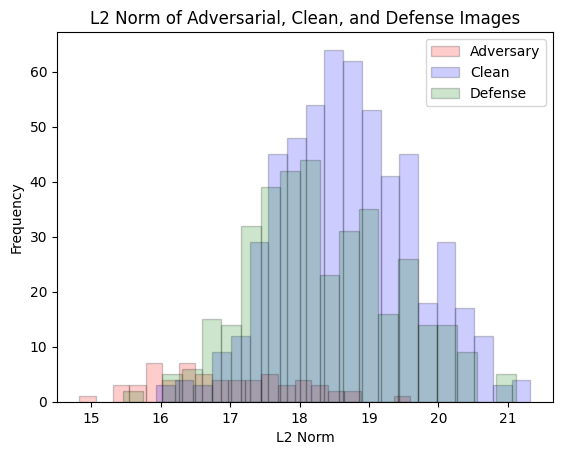

In [60]:
%matplotlib inline

plt.hist(adversaries_l2, bins=20, color='red', edgecolor='black', alpha=0.2, label='Adversary')
plt.hist(clean_imgs_l2, bins=20, color='blue', edgecolor='black', alpha=0.2, label='Clean')
plt.hist(defense_imgs_l2, bins=20, color='green', edgecolor='black', alpha=0.2, label='Defense')

plt.title("L2 Norm of Adversarial, Clean, and Defense Images")
plt.xlabel("L2 Norm")
plt.ylabel("Frequency")
plt.legend()

plt.show()

## 6.2 Cosine Similarity

In [61]:
import torch.nn.functional as F
%matplotlib inline

def compute_cosine_similarity_with_clean(img_names, img_embs, clean_names, clean_embeddings, image_type):
  clean_embeddings_dict = {}
  cosine_similarities = []

  # Loop through the adversarial/defense images and compute cosine similarity with the clean images
  for name, emb in zip(img_names, img_embs):
      # Extract the prefix
      split = name.split('_')
      if split[0] == 'val':
        prefix = split[0]+'_'+split[1]
      else:
        prefix = split[0]
      # Find the index of the clean image with the same prefix
      clean_img_index = next((i for i, name in enumerate(clean_names) if name.startswith(prefix)), None)
      # If a clean image is found, compute the cosine similarity
      if clean_img_index is not None:
        clean_emb = clean_embeddings[clean_img_index]
        clean_embeddings_dict[prefix] = clean_embeddings[clean_img_index]
        # Calculate cosine similarity and add to the list
        cos_sim = F.cosine_similarity(clean_emb.unsqueeze(0), emb.unsqueeze(0))
        cosine_similarities.append(cos_sim.item())
  print(f"Computed cosine similarity of the {image_type} image to the corresponding CLEAN image!")
  return clean_embeddings_dict, cosine_similarities

# Get cosine similarities between adversarial and defense images, and their corresponding clean images
clean_embs = image_features_matrix[adversary_end:clean_end]

adv_embs = image_features_matrix[:adversary_end]
adv_clean_embs_dict, adv_cosine_similarities = compute_cosine_similarity_with_clean(adversary_names, adv_embs, clean_names, clean_embs, image_type='ADVERSARIAL')

def_embs = image_features_matrix[clean_end:]
def_clean_embs_dict, def_cosine_similarities = compute_cosine_similarity_with_clean(defense_names, def_embs, clean_names, clean_embs, image_type='DEFENSE')

clean_embeddings_dict = {**adv_clean_embs_dict, **def_clean_embs_dict}

Computed cosine similarity of the ADVERSARIAL image to the corresponding CLEAN image!
Computed cosine similarity of the DEFENSE image to the corresponding CLEAN image!


In [62]:
clean_embeddings_dict.keys()

dict_keys(['bird', 'dog', 'expedia', 'lemon', 'lighthouse', 'tower', 'val_001', 'val_002', 'val_003', 'val_004', 'val_005', 'val_006', 'val_007', 'val_008', 'val_009', 'val_010', 'val_011', 'val_012', 'val_013', 'val_014', 'val_015', 'val_016', 'val_017', 'val_018', 'val_019', 'val_020', 'val_021', 'val_022', 'val_023', 'val_024', 'val_025', 'val_026', 'val_027', 'val_028', 'val_029', 'val_030', 'val_031', 'val_032', 'val_033', 'val_034', 'val_035', 'val_036', 'val_037', 'val_038', 'val_039', 'val_040', 'val_041', 'val_042', 'val_043', 'val_044', 'val_045', 'val_046', 'val_047', 'val_048', 'val_049', 'val_050', 'wolf'])

In [63]:
def compute_nearest_neighbor_cossim(all_names, all_embs, target_names, target_embs, nn_type):
  # nearest neighbor (any image) cosine similarity for each target image
  nearest_neighbor_similarities = []
  for i, emb in enumerate(target_embs):
      # Compute cosine similarity of image with all other embeddings
      similarities = F.cosine_similarity(emb.unsqueeze(0), all_embs, dim=1)
      # Zero out the similarity with itself by setting it to a large negative value
      similarities = similarities[np.round(similarities, 6) != 1]
      # Find the maximum similarity, which is the nearest neighbor
      max_idx, max_val = np.argmax(similarities), similarities.max().item()
      print(f"Image of Interest: {target_names[i]}; Nearest Neighbor: {all_names[max_idx]}")
      nearest_neighbor_similarities.append(max_val)
  print(f"Computed cosine similarity of the {nn_type} image to the nearest neighbor image!")
  return nearest_neighbor_similarities

In [64]:
clean_nn_cosine_similarities = compute_nearest_neighbor_cossim(all_names, image_features_matrix, clean_names, clean_embs, 'CLEAN')

Image of Interest: bird; Nearest Neighbor: val_481
Image of Interest: dog; Nearest Neighbor: dog_eps32_cropped
Image of Interest: ducks; Nearest Neighbor: val_048_eps32
Image of Interest: expedia; Nearest Neighbor: expedia_eps32_cropped
Image of Interest: lemon; Nearest Neighbor: lemon_eps32_bitDepthReduced
Image of Interest: lighthouse; Nearest Neighbor: lighthouse_eps32_jpegCompressed
Image of Interest: tower; Nearest Neighbor: tower_eps32_bitDepthReduced
Image of Interest: wolf; Nearest Neighbor: wolf_eps255_jpegCompressed
Image of Interest: val_001; Nearest Neighbor: val_385
Image of Interest: val_002; Nearest Neighbor: val_002_eps32_bitDepthReduced
Image of Interest: val_003; Nearest Neighbor: val_003_eps32_bitDepthReduced
Image of Interest: val_004; Nearest Neighbor: val_004_eps32_bitDepthReduced
Image of Interest: val_005; Nearest Neighbor: val_005_eps32_bitDepthReduced
Image of Interest: val_006; Nearest Neighbor: val_006_eps32_cropped
Image of Interest: val_007; Nearest Neighb

In [65]:
adversary_nn_cosine_similarities = compute_nearest_neighbor_cossim(all_names, image_features_matrix, adversary_names, adv_embs, 'ADVERSARY')

Image of Interest: bird_eps255; Nearest Neighbor: wolf_eps32
Image of Interest: bird_eps32; Nearest Neighbor: bird_eps32_rescaled
Image of Interest: dog_eps32; Nearest Neighbor: bird_eps32_tvDenoised
Image of Interest: expedia_eps255; Nearest Neighbor: expedia_eps255_rescaled
Image of Interest: expedia_eps32; Nearest Neighbor: expedia_eps32_rescaled
Image of Interest: lemon_eps255; Nearest Neighbor: lemon_eps255_rescaled
Image of Interest: lemon_eps32; Nearest Neighbor: lemon_eps32_rescaled
Image of Interest: lighthouse_eps32; Nearest Neighbor: lemon_eps32_tvDenoised
Image of Interest: tower_eps255; Nearest Neighbor: tower_eps255_rescaled
Image of Interest: tower_eps32; Nearest Neighbor: tower_eps32_noisy
Image of Interest: val_001_eps32; Nearest Neighbor: tower_eps32_tvDenoised
Image of Interest: val_002_eps32; Nearest Neighbor: val_002_eps32_rescaled
Image of Interest: val_003_eps32; Nearest Neighbor: val_002_eps32_tvDenoised
Image of Interest: val_004_eps32; Nearest Neighbor: val_00

In [66]:
defense_nn_cosine_similarities = compute_nearest_neighbor_cossim(all_names, image_features_matrix, defense_names, def_embs, 'DEFENSE')

Image of Interest: bird_eps255_bitDepthReduced; Nearest Neighbor: bird
Image of Interest: bird_eps255_cropped; Nearest Neighbor: bird_eps32_bitDepthReduced
Image of Interest: bird_eps255_jpegCompressed; Nearest Neighbor: bird_eps32_cropped
Image of Interest: bird_eps255_noisy; Nearest Neighbor: bird_eps32_jpegCompressed
Image of Interest: bird_eps255_rescaled; Nearest Neighbor: bird_eps255_rescaled
Image of Interest: bird_eps255_tvDenoised; Nearest Neighbor: bird_eps255_rescaled
Image of Interest: bird_eps32_bitDepthReduced; Nearest Neighbor: bird_eps32_rescaled
Image of Interest: bird_eps32_cropped; Nearest Neighbor: bird_eps255_cropped
Image of Interest: bird_eps32_jpegCompressed; Nearest Neighbor: bird_eps255_jpegCompressed
Image of Interest: bird_eps32_noisy; Nearest Neighbor: bird_eps255_noisy
Image of Interest: bird_eps32_rescaled; Nearest Neighbor: bird_eps32_bitDepthReduced
Image of Interest: bird_eps32_tvDenoised; Nearest Neighbor: dog
Image of Interest: dog_eps32_bitDepthRedu

In [67]:
print("adv_cosine_similarities", adv_cosine_similarities)
print("def_cosine_similarities", def_cosine_similarities)
print("clean_nn_cosine_similarities", clean_nn_cosine_similarities)
print("adversary_nn_cosine_similarities", adversary_nn_cosine_similarities)
print("defense_nn_cosine_similarities", defense_nn_cosine_similarities)

adv_cosine_similarities [0.6625200510025024, 0.44336724281311035, 0.5750837922096252, 0.6006052494049072, 0.5528649091720581, 0.5559648871421814, 0.7806344032287598, 0.5624710321426392, 0.5236268639564514, 0.6304489374160767, 0.5677908658981323, 0.6980566382408142, 0.6771008372306824, 0.4366580843925476, 0.5738884806632996, 0.6798954606056213, 0.5553422570228577, 0.6255241632461548, 0.5752833485603333, 0.5596907138824463, 0.7271604537963867, 0.6482484340667725, 0.64701247215271, 0.5378071069717407, 0.8490163683891296, 0.8014288544654846, 0.6386155486106873, 0.690726101398468, 0.6206563115119934, 0.7530068159103394, 0.748915433883667, 0.3635461628437042, 0.6263418197631836, 0.5259432196617126, 0.5420272350311279, 0.3083761930465698, 0.5967491269111633, 0.6282424926757812, 0.7066261768341064, 0.5567449927330017, 0.7246454954147339, 0.6318458318710327, 0.6475610136985779, 0.47725918889045715, 0.6412053108215332, 0.5550689697265625, 0.5534719228744507, 0.5632277727127075, 0.390149295330047

### 6.2.1 Nearest Neighbor of Clean, Corresponding Clean Img for Adversay & Defenses

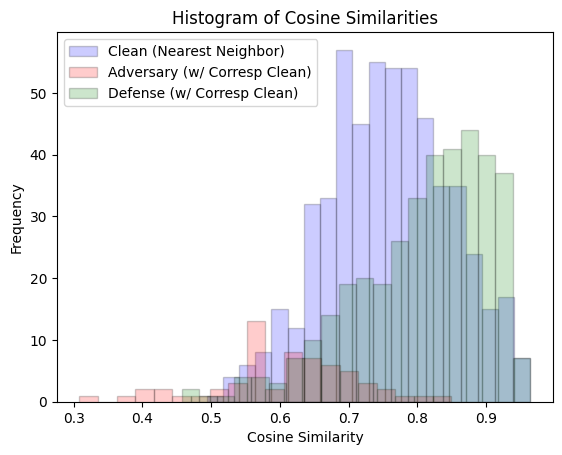

In [68]:
# plot the histogram of cosine similarities
plt.hist(clean_nn_cosine_similarities, bins=20, color='blue', edgecolor='black', alpha=0.2, label='Clean (Nearest Neighbor)')
plt.hist(adv_cosine_similarities, bins=20, color='red', edgecolor='black', alpha=0.2, label='Adversary (w/ Corresp Clean)')
plt.hist(def_cosine_similarities, bins=20, color='green', edgecolor='black', alpha=0.2, label='Defense (w/ Corresp Clean)')

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')
plt.legend()
plt.show()

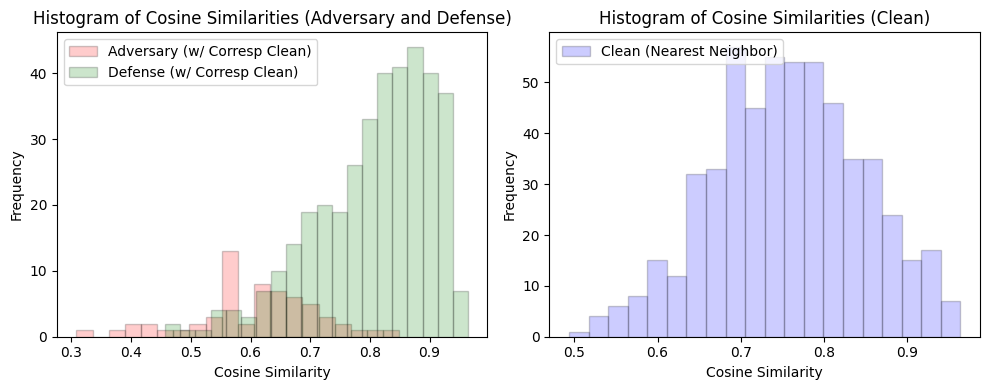

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot (for red and green histograms)
axs[0].hist(adv_cosine_similarities, bins=20, color='red', edgecolor='black', alpha=0.2, label='Adversary (w/ Corresp Clean)')
axs[0].hist(def_cosine_similarities, bins=20, color='green', edgecolor='black', alpha=0.2, label='Defense (w/ Corresp Clean)')
axs[0].set_xlabel('Cosine Similarity')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Cosine Similarities (Adversary and Defense)')
axs[0].legend()

# Plot the second subplot (for the blue histogram)
axs[1].hist(clean_nn_cosine_similarities, bins=20, color='blue', edgecolor='black', alpha=0.2, label='Clean (Nearest Neighbor)')
axs[1].set_xlabel('Cosine Similarity')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Cosine Similarities (Clean)')
axs[1].legend()

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


The histogram on the left shows two clear cluster of the cosine similarity, the right histogram shows the clean images with their neareast neighbor to illustrate what the number means.

plot w/ different y-axis, another axis e.g. 01-5

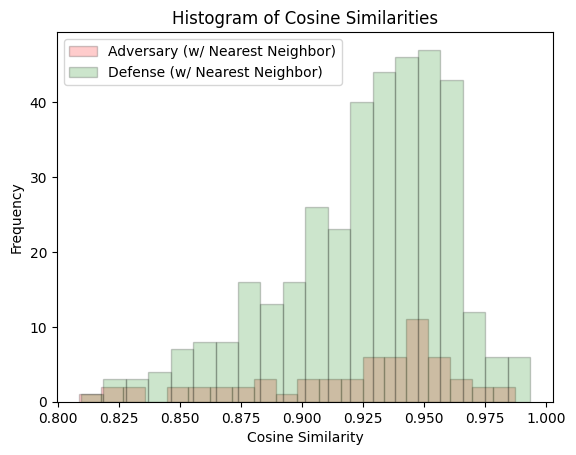

In [42]:
# plot the histogram of cosine similarities
plt.hist(adversary_nn_cosine_similarities, bins=20, color='red', edgecolor='black', alpha=0.2, label='Adversary (w/ Nearest Neighbor)')
plt.hist(defense_nn_cosine_similarities, bins=20, color='green', edgecolor='black', alpha=0.2, label='Defense (w/ Nearest Neighbor)')

plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')
plt.legend()
plt.show()

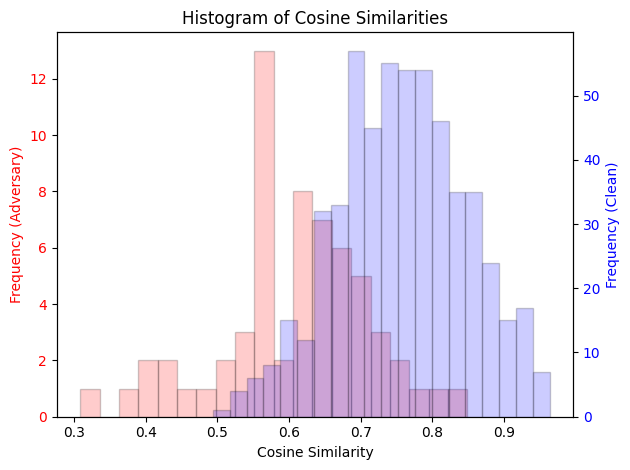

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots
fig, ax2 = plt.subplots()

# Plotting the adversary data with red color on ax2
ax2.hist(adv_cosine_similarities, bins=20, color='red', edgecolor='black', alpha=0.2, label='Adversary (w/ Corresp Clean)')
ax2.set_xlabel('Cosine Similarity')
ax2.set_ylabel('Frequency (Adversary)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Creating another y-axis for the clean data
ax1 = ax2.twinx()
ax1.hist(clean_nn_cosine_similarities, bins=20, color='blue', edgecolor='black', alpha=0.2, label='Clean (Nearest Neighbor)')  # More transparent
ax1.set_ylabel('Frequency (Clean)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Adding a title and showing the plot
plt.title('Histogram of Cosine Similarities')
fig.tight_layout()  # For better spacing
plt.show()
